# Build a regression model using Scikit-learn: regression four ways

### In this notebook you will learn about visualising the data set by creating different types of plots and then how to train it for two types of Regression: basic linear regression and polynomial regression. The data used is the US pumpkin price data, the objective is to predict the price of pumpkin depending on diffenrent inputs



### Let's get started:
#### In order to understand the data set we need to dig deeper in the data and ask questions like:
#### What is the best time to buy pumpkin? Should I buy them in half-bushel baskets or by the 1 1/9 bushel box?

In [ ]:
###importing packages and libraries required for visualisation and data slicing and dicing

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

### importing the data set as pandas data frame
pumpkins = pd.read_csv('./US-pumpkins.csv')

pumpkins.head()

#### Below we are doing the following:
#### We will first get pumpkin priced by bushel
#### Convert the date to month to get the month so that we could find if there is a correlation between month and pumpin price
#### Calculate the price to be an average of high and low prices
#### Convert the price to reflect the pricing by bushel quantity

In [8]:


pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

#print(pumpkins)



column_to_select = ['Package', 'Variety','City Name', 'Low Price','High Price','Date']   ###selecting relevant columns in the data
pumpkins = pumpkins.loc[:,column_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2      ###averaging the price
month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)  #####taking the day of the year

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()

,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


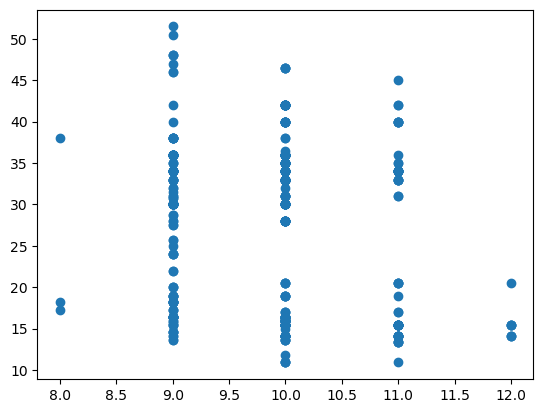

In [9]:
####plotting the scatter plot. A scatterplot reminds us that we only have month data from August through December. 
####We probably need more data to be able to draw conclusions in a linear fashion.


import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

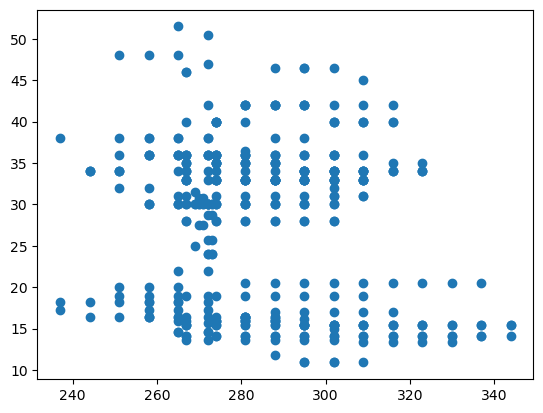

In [10]:
plt.scatter('DayOfYear','Price',data=new_pumpkins)

In [11]:
#### Let's see if there is correlation:

print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))


####Looks like correlation is pretty small, 
####but there is some other more important relationship - because price points in the plot above seem to have 
###several distinct clusters. 

-0.14878293554077537
-0.16673322492745402


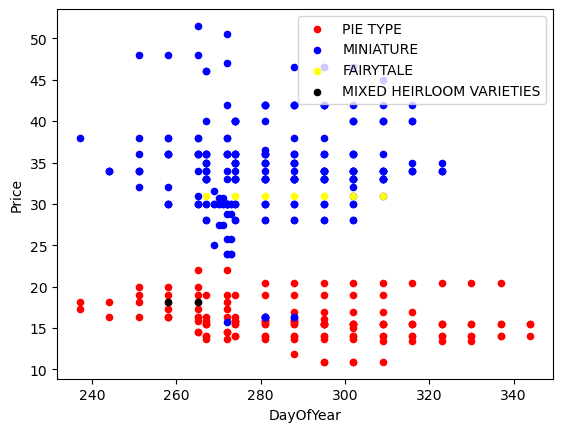

In [14]:
#### Let's make a plot that will show different pumpkin varieties:


ax = None
colors = ['red','blue','yellow','black']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    ax = df.plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

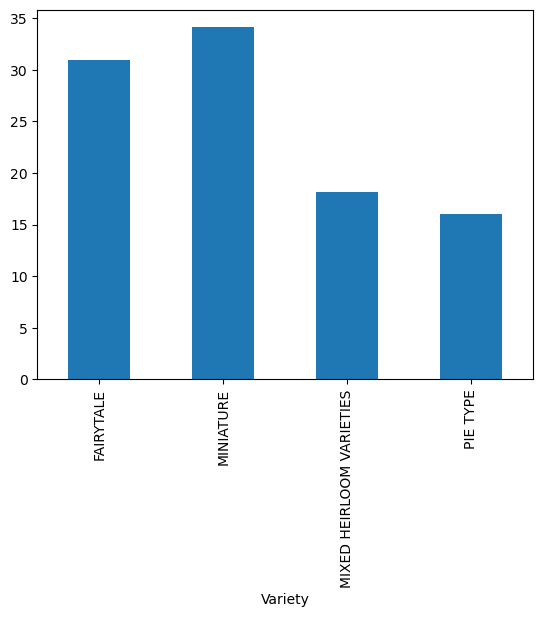

In [15]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

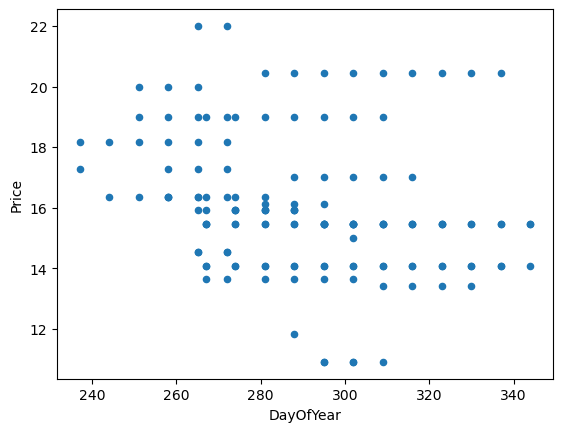

In [16]:
#### taking just the pie-type


pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
pie_pumpkins.plot.scatter('DayOfYear','Price') 

In [17]:
##### Now let's train our linear model using Scikit learning


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [18]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [21]:
pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.77 (17.2%)


In [22]:
score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.0446060633502835


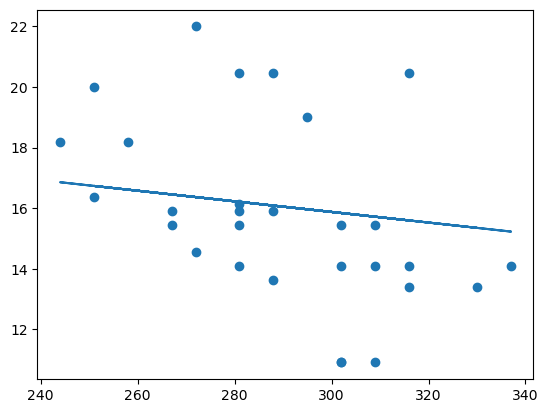

In [23]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [25]:
pd.get_dummies(new_pumpkins['Variety'])

,FAIRYTALE,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
70,0,0,0,1
71,0,0,0,1
72,0,0,0,1
73,0,0,0,1
74,0,0,0,1
...,...,...,...,...
1738,0,1,0,0
1739,0,1,0,0
1740,0,1,0,0
1741,0,1,0,0


In [26]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [27]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

In [28]:
# set up training data
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)

# calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.26%)
Model determination:  0.9652399813840176
